In [72]:
# Idea: ich mache "irm_speech, irm_noise = get_irms(stft_clean, stft_noise)" mit NN
# Rest ist wie in https://pytorch.org/audio/0.12.0/tutorials/mvdr_tutorial.html#compute-irms
import torch
import torchaudio
import torchaudio.functional as F
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset
import numpy

In [73]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

In [74]:
# Helper functions
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8)
    print(spectrogram.shape)
    spectrogram = spectrogram.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()

In [75]:
# Load audio
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms
waveform_mix = waveform_clean + waveform_noise

# Improve Robustness with double precision floating points
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

In [77]:
waveform_clean.shape

torch.Size([8, 64000])

In [76]:
# Compute STFT
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

torch.Size([513, 251])


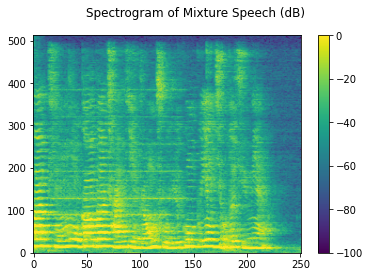

In [85]:
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
Audio(waveform_mix[0], rate=SAMPLE_RATE)

torch.Size([513, 251])


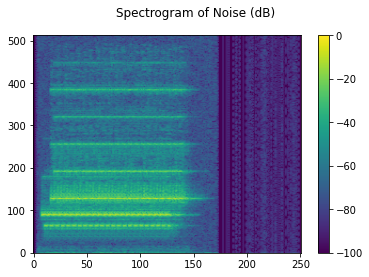

In [86]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

In [87]:
REFERENCE_CHANNEL = 0

In [88]:
# Get Masks
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]

irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

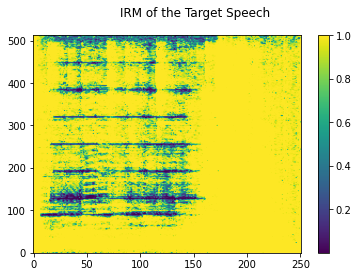

In [89]:
plot_mask(irm_speech, "IRM of the Target Speech")

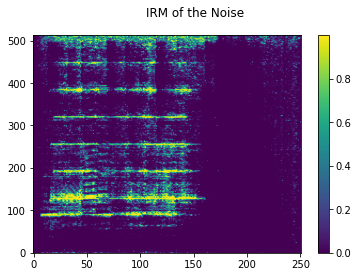

In [90]:
plot_mask(irm_noise, "IRM of the Noise")

In [91]:
# computes the time-invariant PSD matrix given the multi-channel complex-valued STFT coefficients of the mixture speech and the time-frequency mask.

psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

In [92]:
# Apply BF
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

torch.Size([513, 251])


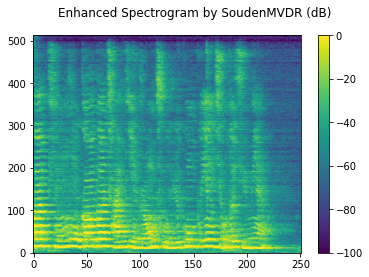

Si-SNR score: 15.035907294699214


In [93]:
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
print(f"Si-SNR score: {si_snr(waveform_souden, waveform_clean[0:1])}")
Audio(waveform_souden, rate=SAMPLE_RATE)

## Neural Net implementation

In [319]:
from torch.nn import Module, LeakyReLU, MaxPool1d, Conv2d, Linear, Softmax, BatchNorm1d, CrossEntropyLoss, BCELoss, Sigmoid, Tanh, LSTM, MSELoss
from torch import flatten
from torch.optim import Adam
import time
import torch
from pytorch_model_summary import summary


In [296]:
HIDDEN_SIZE=8
INIT_LR = 0.01
BATCH_SIZE = 1#64
EPOCHS = 10

In [297]:
# MASK NET
class MaskNetSpeech(Module):
    def __init__(self,noise=False):
        super(MaskNetSpeech, self).__init__()
        self.noise = noise
        self.type(torch.complex128)
        self.lstm = LSTM(input_size=8, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        #input: ([8, 513, 251])
        x = x.reshape(513,251,8)
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x).type(torch.double)
        output = self.sigmoid(x)
        output = output.reshape(513,251)
        return output
        #output: 513x251

print(summary(MaskNetSpeech(),torch.zeros((513, 251, 8))))#(8, 513, 251)))

# MASK NET
class MaskNetNoise(Module):
    def __init__(self,noise=False):
        super(MaskNetNoise, self).__init__()
        self.noise = noise
        self.type(torch.complex128)
        self.lstm = LSTM(input_size=8, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        #input: ([8, 513, 251])
        x = x.reshape(513,251,8)
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x).type(torch.double)
        output = self.sigmoid(x)
        output = output.reshape(513,251)
        return output
        #output: 513x251

print(summary(MaskNetNoise(),torch.zeros((513, 251, 8))))#(8, 513, 251))

------------------------------------------------------------------------------------------------
      Layer (type)                                 Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,816           2,816
          Linear-2                                [513, 251, 1]              17              17
         Sigmoid-3                                [513, 251, 1]               0               0
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
      Layer (type)                                 Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,816           2,816
          Linear-2                                [513, 251, 1]  

In [287]:

#device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNetSpeech()#.to(device)
model.type(torch.complex128)

opt = Adam(model.parameters(), lr=INIT_LR)

lossBCE = BCELoss()

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

print("[INFO] training the network...")
startTime = time.time()

for epoch in range(0, EPOCHS):
    print("Epoch:",epoch)
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = stft_mix
    trainY = irm_speech
    for i in range(0,1):
            (x, y) = (trainX,trainY)#(trainX[i],trainY[i])
            #(x, y) = (x.to(device), y.to(device))
            # perform a forward pass and calculate the training loss
            #print(next(model.parameters()).is_cuda)
            pred = model(x)
            loss = lossBCE(pred, y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += loss
            # trainCorrect += (pred.argmax(1) == y).type(
            #     torch.float).sum().item()

[INFO] training the network...
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


In [289]:
INIT_LR = 0.01
BATCH_SIZE = 1#64
EPOCHS = 10

#device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_n = MaskNetNoise(noise=True)#.to(device)
model_n.type(torch.complex128)

opt = Adam(model_n.parameters(), lr=INIT_LR)

lossBCE = BCELoss()

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

print("[INFO] training the network...")
startTime = time.time()

for epoch in range(0, EPOCHS):
    print("Epoch:",epoch)
    # Train Mode
    model_n.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = stft_mix
    trainY = irm_noise
    for i in range(0,1):
            (x, y) = (trainX,trainY)#(trainX[i],trainY[i])
            #(x, y) = (x.to(device), y.to(device))
            # perform a forward pass and calculate the training loss
            #print(next(model.parameters()).is_cuda)
            pred = model_n(x)
            loss = lossBCE(pred, y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += loss
            # trainCorrect += (pred.argmax(1) == y).type(
            #     torch.float).sum().item()

[INFO] training the network...
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


In [290]:
prediction_noise = model_n(stft_mix)
prediction_speech = model(stft_mix)


In [291]:
#prediction_speech = model(stft_mix.reshape(513,251,8)).reshape(513,251)
#prediction_noise = model_n(stft_mix.reshape(513,251,8)).reshape(513,251)

psd_transform = torchaudio.transforms.PSD()
psd_speech = psd_transform(stft_mix, prediction_speech)
psd_noise = psd_transform(stft_mix, prediction_noise)

torch.Size([513, 251])


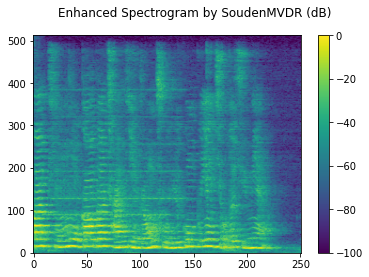

Si-SNR score: 27.039525031195502


In [292]:
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
print(f"Si-SNR score: {si_snr(waveform_souden, waveform_clean[0:1])}")
Audio(waveform_souden.detach(), rate=SAMPLE_RATE)

In [293]:
torchaudio.save("output.wav", waveform_souden.float(), SAMPLE_RATE)


## End-To-End Training

In [313]:
# # MASK NET

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.type(torch.cdouble)
        self.noise = noise
        self.lstm = LSTM(input_size=8, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()
        # Second subnet for noise prediction
        self.noise2 = noise
        self.lstm2 = LSTM(input_size=8, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc2 = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid2 = Sigmoid()

    def forward(self,x):
        # Speech prediction
        y = x.reshape(513,251,8)
        y, (h_n, c_n) = self.lstm(y)
        y = self.fc(y).type(torch.double)
        speech_pred = self.sigmoid(y)
        speech_pred = speech_pred.reshape(513,251).type(torch.cdouble)

        # Noise prediction
        z = x.reshape(513,251,8)
        z, (h_n, c_n) = self.lstm2(z)
        z = self.fc2(z).type(torch.double)
        noise_pred = self.sigmoid2(z)
        noise_pred = noise_pred.reshape(513,251).type(torch.cdouble)


        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(x, speech_pred)
        psd_noise = psd_transform(x, noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])
        
        return waveform_souden.reshape(-1)

print(summary(MaskNet(),torch.zeros((8, 513, 251))))


------------------------------------------------------------------------------------------------
      Layer (type)                                 Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,816           2,816
          Linear-2                                [513, 251, 1]              17              17
         Sigmoid-3                                [513, 251, 1]               0               0
            LSTM-4     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,816           2,816
          Linear-5                                [513, 251, 1]              17              17
         Sigmoid-6                                [513, 251, 1]               0               0
Total params: 5,666
Trainable params: 5,666
Non-trainable params: 0
------------------------------------------------------------------------------------------------


In [320]:

#device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet()#.to(device)
model.type(torch.complex128)

opt = Adam(model.parameters(), lr=INIT_LR)

lossMSE = MSELoss()

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

print("[INFO] training the network...")
startTime = time.time()

for epoch in range(0, EPOCHS):
    print("Epoch:",epoch)
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = stft_mix
    trainY = waveform_clean[0]
    for i in range(0,1):
            (x, y) = (trainX,trainY)#(trainX[i],trainY[i])
            #(x, y) = (x.to(device), y.to(device))
            # perform a forward pass and calculate the training loss
            #print(next(model.parameters()).is_cuda)
            pred = model(x)
            loss = lossMSE(pred, y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            totalTrainLoss += loss
            # trainCorrect += (pred.argmax(1) == y).type(
            #     torch.float).sum().item()

[INFO] training the network...
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


## Prepare Training Data

In [1]:
import json
import torchaudio
import matplotlib.pyplot as plt
import torch
from datetime import time
import numpy as np

/Users/danilfedorovsky/miniforge3/envs/pytorch/lib/python3.9/site-packages/torchaudio/_internal/module_utils.py:99: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [2]:
## decide what to load
SESSION = "S02"
transcript_path = "/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/CHiME5/transcriptions/dev/" + SESSION + ".json"
#'/project/data_asr/CHiME5/data/CHiME5/transcriptions/dev/' + SESSION
data_path = "/Users/danilfedorovsky/Documents/10 Collection/00 Studium/00 Letztes Semester/Masterarbeit/Data/CHiME5/audio/dev/"

In [3]:
with open(transcript_path, 'r') as f:
    transcript = json.load(f)

In [4]:
u1_times = []
speaker_times = []
for entry in transcript:
    #print(entry["start_time"]["U01"])
    #print(entry["end_time"]["U01"])
    try:
        speaker_times.append([entry["speaker"],time.fromisoformat("0"+str(entry["start_time"]["U01"])+"0"),time.fromisoformat("0"+str(entry["end_time"]["U01"])+"0")])
        u1_times.append([time.fromisoformat("0"+str(entry["start_time"]["U01"])+"0"),time.fromisoformat("0"+str(entry["end_time"]["U01"])+"0")])
    except:
        # if redacted
        pass

print(speaker_times[0])
print(u1_times[0])
print(len(speaker_times)==len(u1_times))

['P05', datetime.time(0, 0, 40, 630000), datetime.time(0, 0, 43, 850000)]
[datetime.time(0, 0, 40, 630000), datetime.time(0, 0, 43, 850000)]
True


In [5]:
# 2h 28 min 24 s = 8904s
P05, sample_rate = torchaudio.load(data_path+"S02_P05.wav")
P06, _ = torchaudio.load(data_path+"S02_P06.wav")
P07, _ = torchaudio.load(data_path+"S02_P07.wav")
P08, _ = torchaudio.load(data_path+"S02_P08.wav")
U01, _ = torchaudio.load(data_path+"S02_U01.CH1.wav")
U012, _ = torchaudio.load(data_path+"S02_U01.CH2.wav")
#P05 = P05[0].reshape(1,-1)
#P06 = P06[0].reshape(1,-1)
#P07 = P07[0].reshape(1,-1)
#P08 = P08[0].reshape(1,-1)
print(U01.size(dim=1)/sample_rate, "seconds")

8904.04 seconds


In [6]:
# Cut the relevant segments
X = []#np.array([])#[]#torch.Tensor()
Y = []#np.array([])#[]#torch.Tensor()

def time_to_sample(time:time):
    return int(sample_rate*(time.hour*3600+time.minute*60+time.second+time.microsecond/1000000))

# Input
for start, end in u1_times:
    start = time_to_sample(start)
    end = time_to_sample(end)
    #X = torch.cat((X, U01[0][start:end]), 0)
    X.append([U01[0][start:end],U012[0][start:end]])
print("Input ready")

# Label
for speaker,start,end in speaker_times:
    #print(speaker,start,end)
    start = time_to_sample(start)
    end = time_to_sample(end)
    if speaker == "P05":
        #Y = torch.cat((Y, P05[0][start:end]), 0)
        #Y.append([P05[0][start:end],P05[1][start:end]])
        Y.append(P05[0][start:end])
    if speaker == "P06":
        #Y = torch.cat((Y, P06[0][start:end]), 0)
        Y.append(P06[0][start:end])
    if speaker == "P07":
        #Y = torch.cat((Y, P07[0][start:end]), 0)
        Y.append(P07[0][start:end])
    if speaker == "P08":
        #Y = torch.cat((Y, P08[0][start:end]), 0)
        Y.append(P08[0][start:end])

print("Label ready")
#print(X.size(0)==Y.size(0))
print(len(X)==len(Y))

Input ready
Label ready
True


## Training on CHIME

In [29]:
from torch.nn import Module, LeakyReLU, MaxPool1d, Conv2d, Linear, Softmax, BatchNorm1d, CrossEntropyLoss, BCELoss, Sigmoid, Tanh, LSTM, MSELoss
from torch import flatten
from torch.optim import Adam
import time
import torch
from pytorch_model_summary import summary
from tqdm import tqdm
import torchaudio

In [30]:
HIDDEN_SIZE=8
INIT_LR = 0.01
BATCH_SIZE = 1#64
SAMPLE_RATE = 16000
EPOCHS = 1
INPUT_CHANNEL = 2
REFERENCE_CHANNEL = 0

N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)
global i
i = 0

def prep_x(trainX,i):
        return stft((torch.cat((trainX[i][0].unsqueeze(1),trainX[i][1].unsqueeze(1)),1)).reshape(2,-1)).type(torch.complex64)

In [31]:
# # MASK NET

class MaskNet(Module):
    def __init__(self,noise=False):
        super(MaskNet, self).__init__()
        # First subnet for speech prediction
        self.type(torch.cfloat)
        self.noise = noise
        self.lstm = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid = Sigmoid()
        # Second subnet for noise prediction
        self.noise2 = noise
        self.lstm2 = LSTM(input_size=INPUT_CHANNEL, hidden_size=HIDDEN_SIZE, num_layers=2, bidirectional=True)
        self.fc2 = Linear(in_features=HIDDEN_SIZE*2 ,out_features=1)
        self.sigmoid2 = Sigmoid()

    def forward(self,x):
        # Speech prediction
        y = x.reshape(513,-1,INPUT_CHANNEL)#(513,251,INPUT_CHANNEL)
        y, (h_n, c_n) = self.lstm(y)
        y = self.fc(y).type(torch.double)
        speech_pred = self.sigmoid(y)
        speech_pred = speech_pred.reshape(513,-1).type(torch.cfloat)
        #print("speech_pred.shape",speech_pred.shape)

        # Noise prediction
        z = x.reshape(513,-1,INPUT_CHANNEL)
        z, (h_n, c_n) = self.lstm2(z)
        z = self.fc2(z).type(torch.double)
        noise_pred = self.sigmoid2(z)
        noise_pred = noise_pred.reshape(513,-1).type(torch.cfloat)

        psd_transform = torchaudio.transforms.PSD()
        psd_speech = psd_transform(x, speech_pred)
        psd_noise = psd_transform(x, noise_pred)
        mvdr_transform = torchaudio.transforms.SoudenMVDR()
        x = x.type(torch.cfloat)
        stft_souden = mvdr_transform(x, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
        #print("stft_souden",stft_souden.shape)
        waveform_souden = istft(stft_souden, length=len(X[i][0]))#X[i].shape[-1])
        waveform_souden[waveform_souden != waveform_souden] = 1.0000e-10 
        print(waveform_souden)
        return waveform_souden.reshape(-1)

print(summary(MaskNet(),torch.zeros((INPUT_CHANNEL, 513, 251))))


tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<AsStridedBackward0>)
------------------------------------------------------------------------------------------------
      Layer (type)                                 Output Shape         Param #     Tr. Param #
            LSTM-1     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,432           2,432
          Linear-2                                [513, 251, 1]              17              17
         Sigmoid-3                                [513, 251, 1]               0               0
            LSTM-4     [513, 251, 16], [4, 251, 8], [4, 251, 8]           2,432           2,432
          Linear-5                                [513, 251, 1]              17              17
         Sigmoid-6                                [513, 251, 1]               0               0
Total params: 4,898
Trainable params: 4,898
Non-trainable params: 0
----------------------------------------------------------------------------------------------

In [32]:

#device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = MaskNet()#.to(device)
model.type(torch.complex64)

opt = Adam(model.parameters(), lr=INIT_LR)

lossMSE = MSELoss()

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

print("[INFO] training the network...")
#startTime = time.time()

for epoch in range(0, EPOCHS):
    print("Epoch:",epoch,"/1")
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    trainX = X
    trainY = Y

    global i
    for i in tqdm(range(0,100)):#len(trainX))):
        (x, y) = (stft((torch.cat((trainX[i][0].unsqueeze(1),trainX[i][1].unsqueeze(1)),1)).reshape(2,-1)),trainY[i])#(trainX[i],trainY[i])
        #(x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        #print(next(model.parameters()).is_cuda)
        print(x.shape)
        pred = model(x)
        loss = lossMSE(pred, y)

        #print("Loss:",loss)
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        # trainCorrect += (pred.argmax(1) == y).type(
        #     torch.float).sum().item()

[INFO] training the network...
Epoch: 0 /1


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([2, 513, 202])
tensor([ 0.0005,  0.0031,  0.0023,  ..., -0.0079, -0.0086, -0.0067],
       grad_fn=<AsStridedBackward0>)


  1%|          | 1/100 [00:02<04:11,  2.54s/it]

torch.Size([2, 513, 179])
tensor([ 0.0077,  0.0080,  0.0104,  ..., -0.0022, -0.0011,  0.0081],
       grad_fn=<AsStridedBackward0>)


  2%|▏         | 2/100 [00:04<03:08,  1.92s/it]

torch.Size([2, 513, 178])
tensor([-0.0002, -0.0041,  0.0015,  ...,  0.0246,  0.0301,  0.0425],
       grad_fn=<AsStridedBackward0>)


  3%|▎         | 3/100 [00:05<03:01,  1.87s/it]

torch.Size([2, 513, 118])
tensor([ 0.0152,  0.0047,  0.0156,  ..., -0.0150,  0.0050, -0.0195],
       grad_fn=<AsStridedBackward0>)


  4%|▍         | 4/100 [00:07<02:33,  1.60s/it]

torch.Size([2, 513, 295])
tensor([-0.0028, -0.0122, -0.0114,  ..., -0.0127, -0.0026, -0.0047],
       grad_fn=<AsStridedBackward0>)


  5%|▌         | 5/100 [00:10<03:26,  2.17s/it]

torch.Size([2, 513, 242])
tensor([1.7834e-03, 5.6711e-05, 4.6569e-03,  ..., 4.7405e-03, 1.0182e-02,
        1.1812e-02], grad_fn=<AsStridedBackward0>)


  6%|▌         | 6/100 [00:12<03:15,  2.08s/it]

torch.Size([2, 513, 127])
tensor([-0.0139, -0.0128,  0.0010,  ...,  0.0026, -0.0015, -0.0005],
       grad_fn=<AsStridedBackward0>)


  7%|▋         | 7/100 [00:13<02:47,  1.80s/it]

torch.Size([2, 513, 36])
tensor([ 0.0043,  0.0038, -0.0037,  ..., -0.0007,  0.0082,  0.0058],
       grad_fn=<AsStridedBackward0>)


  8%|▊         | 8/100 [00:14<02:12,  1.44s/it]

torch.Size([2, 513, 658])
tensor([ 0.0016,  0.0002,  0.0029,  ..., -0.1107, -0.0894, -0.0633],
       grad_fn=<AsStridedBackward0>)


  9%|▉         | 9/100 [00:21<04:51,  3.20s/it]

torch.Size([2, 513, 395])
tensor([-0.0302, -0.0271, -0.0459,  ..., -0.0437, -0.0223, -0.0267],
       grad_fn=<AsStridedBackward0>)


 10%|█         | 10/100 [00:24<05:03,  3.37s/it]

torch.Size([2, 513, 61])
tensor([0.0096, 0.0122, 0.0059,  ..., 0.0282, 0.0374, 0.0409],
       grad_fn=<AsStridedBackward0>)


 11%|█         | 11/100 [00:25<03:49,  2.58s/it]

torch.Size([2, 513, 477])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 12%|█▏        | 12/100 [00:29<04:33,  3.10s/it]

torch.Size([2, 513, 991])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 13%|█▎        | 13/100 [00:37<06:20,  4.37s/it]

torch.Size([2, 513, 221])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 14%|█▍        | 14/100 [00:38<05:05,  3.56s/it]

torch.Size([2, 513, 86])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 15%|█▌        | 15/100 [00:39<03:52,  2.73s/it]

torch.Size([2, 513, 124])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 16%|█▌        | 16/100 [00:40<03:05,  2.21s/it]

torch.Size([2, 513, 240])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 17%|█▋        | 17/100 [00:42<02:50,  2.05s/it]

torch.Size([2, 513, 199])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 18%|█▊        | 18/100 [00:43<02:33,  1.87s/it]

torch.Size([2, 513, 446])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 19%|█▉        | 19/100 [00:47<03:14,  2.40s/it]

torch.Size([2, 513, 330])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 20%|██        | 20/100 [00:50<03:27,  2.59s/it]

torch.Size([2, 513, 415])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 21%|██        | 21/100 [00:54<03:49,  2.91s/it]

torch.Size([2, 513, 541])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 22%|██▏       | 22/100 [00:58<04:26,  3.42s/it]

torch.Size([2, 513, 407])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 23%|██▎       | 23/100 [01:02<04:24,  3.43s/it]

torch.Size([2, 513, 24])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 24%|██▍       | 24/100 [01:02<03:17,  2.60s/it]

torch.Size([2, 513, 27])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 25%|██▌       | 25/100 [01:03<02:30,  2.00s/it]

torch.Size([2, 513, 111])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 26%|██▌       | 26/100 [01:04<02:10,  1.76s/it]

torch.Size([2, 513, 653])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 27%|██▋       | 27/100 [01:09<03:24,  2.80s/it]

torch.Size([2, 513, 461])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 28%|██▊       | 28/100 [01:13<03:42,  3.09s/it]

torch.Size([2, 513, 864])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 29%|██▉       | 29/100 [01:20<04:50,  4.10s/it]

torch.Size([2, 513, 471])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 30%|███       | 30/100 [01:23<04:39,  3.99s/it]

torch.Size([2, 513, 416])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 31%|███       | 31/100 [01:27<04:22,  3.81s/it]

torch.Size([2, 513, 59])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 32%|███▏      | 32/100 [01:28<03:17,  2.90s/it]

torch.Size([2, 513, 482])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 33%|███▎      | 33/100 [01:31<03:32,  3.17s/it]

torch.Size([2, 513, 1029])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 34%|███▍      | 34/100 [01:39<05:07,  4.65s/it]

torch.Size([2, 513, 764])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 35%|███▌      | 35/100 [01:45<05:17,  4.89s/it]

torch.Size([2, 513, 302])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 36%|███▌      | 36/100 [01:47<04:25,  4.15s/it]

torch.Size([2, 513, 553])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 37%|███▋      | 37/100 [01:52<04:25,  4.21s/it]

torch.Size([2, 513, 76])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 38%|███▊      | 38/100 [01:53<03:19,  3.22s/it]

torch.Size([2, 513, 595])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 39%|███▉      | 39/100 [01:57<03:40,  3.62s/it]

torch.Size([2, 513, 64])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 40%|████      | 40/100 [01:58<02:46,  2.77s/it]

torch.Size([2, 513, 384])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 41%|████      | 41/100 [02:01<02:47,  2.83s/it]

torch.Size([2, 513, 818])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 42%|████▏     | 42/100 [02:07<03:38,  3.76s/it]

torch.Size([2, 513, 1062])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 43%|████▎     | 43/100 [02:15<04:44,  4.99s/it]

torch.Size([2, 513, 203])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 44%|████▍     | 44/100 [02:16<03:43,  3.98s/it]

torch.Size([2, 513, 61])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 45%|████▌     | 45/100 [02:17<02:44,  2.99s/it]

torch.Size([2, 513, 90])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 46%|████▌     | 46/100 [02:18<02:07,  2.37s/it]

torch.Size([2, 513, 129])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 47%|████▋     | 47/100 [02:19<01:46,  2.02s/it]

torch.Size([2, 513, 474])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 48%|████▊     | 48/100 [02:23<02:12,  2.55s/it]

torch.Size([2, 513, 457])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 49%|████▉     | 49/100 [02:27<02:29,  2.92s/it]

torch.Size([2, 513, 1124])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 50%|█████     | 50/100 [02:35<03:50,  4.61s/it]

torch.Size([2, 513, 754])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 51%|█████     | 51/100 [02:41<04:01,  4.94s/it]

torch.Size([2, 513, 786])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 52%|█████▏    | 52/100 [02:47<04:10,  5.22s/it]

torch.Size([2, 513, 984])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 53%|█████▎    | 53/100 [02:54<04:31,  5.77s/it]

torch.Size([2, 513, 76])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 54%|█████▍    | 54/100 [02:55<03:19,  4.34s/it]

torch.Size([2, 513, 833])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 55%|█████▌    | 55/100 [03:01<03:42,  4.94s/it]

torch.Size([2, 513, 47])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 56%|█████▌    | 56/100 [03:02<02:42,  3.69s/it]

torch.Size([2, 513, 539])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 57%|█████▋    | 57/100 [03:06<02:47,  3.90s/it]

torch.Size([2, 513, 62])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 58%|█████▊    | 58/100 [03:07<02:04,  2.96s/it]

torch.Size([2, 513, 496])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 59%|█████▉    | 59/100 [03:11<02:13,  3.26s/it]

torch.Size([2, 513, 346])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 60%|██████    | 60/100 [03:14<02:04,  3.12s/it]

torch.Size([2, 513, 521])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 61%|██████    | 61/100 [03:18<02:16,  3.49s/it]

torch.Size([2, 513, 196])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 62%|██████▏   | 62/100 [03:20<01:52,  2.97s/it]

torch.Size([2, 513, 646])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 63%|██████▎   | 63/100 [03:25<02:13,  3.59s/it]

torch.Size([2, 513, 88])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 64%|██████▍   | 64/100 [03:26<01:40,  2.79s/it]

torch.Size([2, 513, 124])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 65%|██████▌   | 65/100 [03:27<01:21,  2.32s/it]

torch.Size([2, 513, 287])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 66%|██████▌   | 66/100 [03:30<01:21,  2.39s/it]

torch.Size([2, 513, 678])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 67%|██████▋   | 67/100 [03:35<01:49,  3.32s/it]

torch.Size([2, 513, 1041])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 68%|██████▊   | 68/100 [03:43<02:30,  4.69s/it]

torch.Size([2, 513, 428])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 69%|██████▉   | 69/100 [03:46<02:12,  4.29s/it]

torch.Size([2, 513, 936])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 70%|███████   | 70/100 [03:53<02:31,  5.07s/it]

torch.Size([2, 513, 582])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 71%|███████   | 71/100 [03:58<02:22,  4.92s/it]

torch.Size([2, 513, 76])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 72%|███████▏  | 72/100 [03:59<01:43,  3.70s/it]

torch.Size([2, 513, 161])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 73%|███████▎  | 73/100 [04:00<01:20,  2.98s/it]

torch.Size([2, 513, 49])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 74%|███████▍  | 74/100 [04:01<00:59,  2.29s/it]

torch.Size([2, 513, 1127])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 75%|███████▌  | 75/100 [04:10<01:49,  4.37s/it]

torch.Size([2, 513, 452])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 76%|███████▌  | 76/100 [04:17<02:00,  5.00s/it]

torch.Size([2, 513, 80])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 77%|███████▋  | 77/100 [04:18<01:33,  4.05s/it]

torch.Size([2, 513, 47])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 78%|███████▊  | 78/100 [04:19<01:08,  3.12s/it]

torch.Size([2, 513, 109])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 79%|███████▉  | 79/100 [04:22<01:00,  2.90s/it]

torch.Size([2, 513, 1001])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 80%|████████  | 80/100 [04:32<01:42,  5.14s/it]

torch.Size([2, 513, 98])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 81%|████████  | 81/100 [04:33<01:14,  3.92s/it]

torch.Size([2, 513, 799])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 82%|████████▏ | 82/100 [04:39<01:23,  4.63s/it]

torch.Size([2, 513, 790])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 83%|████████▎ | 83/100 [04:45<01:24,  4.97s/it]

torch.Size([2, 513, 49])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 84%|████████▍ | 84/100 [04:46<00:59,  3.70s/it]

torch.Size([2, 513, 667])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 85%|████████▌ | 85/100 [04:51<01:01,  4.11s/it]

torch.Size([2, 513, 291])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 86%|████████▌ | 86/100 [04:54<00:52,  3.75s/it]

torch.Size([2, 513, 1164])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 87%|████████▋ | 87/100 [05:04<01:12,  5.59s/it]

torch.Size([2, 513, 747])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 88%|████████▊ | 88/100 [05:09<01:06,  5.58s/it]

torch.Size([2, 513, 239])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 89%|████████▉ | 89/100 [05:11<00:49,  4.46s/it]

torch.Size([2, 513, 176])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 90%|█████████ | 90/100 [05:13<00:35,  3.53s/it]

torch.Size([2, 513, 780])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 91%|█████████ | 91/100 [05:18<00:38,  4.24s/it]

torch.Size([2, 513, 62])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 92%|█████████▏| 92/100 [05:19<00:25,  3.21s/it]

torch.Size([2, 513, 486])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 93%|█████████▎| 93/100 [05:24<00:25,  3.60s/it]

torch.Size([2, 513, 752])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 94%|█████████▍| 94/100 [05:32<00:29,  4.86s/it]

torch.Size([2, 513, 948])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 95%|█████████▌| 95/100 [05:40<00:29,  5.87s/it]

torch.Size([2, 513, 121])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 96%|█████████▌| 96/100 [05:41<00:18,  4.52s/it]

torch.Size([2, 513, 839])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 97%|█████████▋| 97/100 [05:48<00:15,  5.19s/it]

torch.Size([2, 513, 185])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 98%|█████████▊| 98/100 [05:50<00:08,  4.19s/it]

torch.Size([2, 513, 83])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


 99%|█████████▉| 99/100 [05:51<00:03,  3.30s/it]

torch.Size([2, 513, 839])
tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 1.0000e-10, 1.0000e-10,
        1.0000e-10], grad_fn=<AsStridedBackward0>)


100%|██████████| 100/100 [05:59<00:00,  3.59s/it]


In [33]:
PATH = "./modelsave.pt"
torch.save(model.state_dict(), "./modelsave.pt")

## Test model

In [34]:
PATH = "./modelsave.pt"
model = MaskNet()
model.load_state_dict(torch.load(PATH))
model.eval()

MaskNet(
  (lstm): LSTM(2, 8, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (lstm2): LSTM(2, 8, num_layers=2, bidirectional=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid2): Sigmoid()
)

In [36]:
j = 120
#pred_null = model(stft((torch.cat((trainX[j][0].unsqueeze(1),trainX[j][1].unsqueeze(1)),1)).reshape(2,-1)).type(torch.complex64))

In [39]:
def save_sample(i):
    pred_null = model(stft((torch.cat((trainX[i][0].unsqueeze(1),trainX[i][1].unsqueeze(1)),1)).reshape(2,-1)).type(torch.float))
    torchaudio.save("sample_model_output.wav",pred_null.reshape(1,-1),sample_rate)
    torchaudio.save("sample_reference.wav", trainY[i].unsqueeze(1).reshape(1,-1),sample_rate)
    torchaudio.save("sample_input.wav", trainX[i][0].unsqueeze(1).reshape(1,-1),sample_rate)

In [40]:
save_sample(50)

tensor([1.0000e-10, 1.0000e-10, 1.0000e-10,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], grad_fn=<AsStridedBackward0>)
